In [16]:
# Base librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
warnings.simplefilter("ignore")

# Content extraction
import glob

# Prédiction librairies
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Network part
import networkx as nx

In [38]:
def get_articles(name):
    dictio = {}
    list_of_files = glob.glob('../data/news/'+name+'/*.txt')        
    for i,file_name in enumerate(list_of_files):
        id_article = file_name[:-4].split('/')[4]
        dictio[int(id_article)] = open(file_name,'r').read()
    return dictio

def get_words(content):
    vectorizer = TfidfVectorizer(min_df=1,lowercase=False,stop_words='english')
    vectorizer.fit_transform(content.split('.'))
    return vectorizer.get_feature_names()

def get_features(df,vocab=None):
    df['len_content'] = df['content'].apply(lambda x : len(x))
    
    df['len_title'] = df['content'].apply(lambda x: len(x.split('\n')[0]))
    global_vectorizer = TfidfVectorizer(min_df=8,max_df=0.95,lowercase=False,stop_words='english',max_features=400)
    global_vectorizer.fit_transform(df['content'])
    pertinent_vocab = global_vectorizer.get_feature_names()
    
    article_vocab = [get_words(content) for content in df['content']]
    df['nb_relevant'] = [len (set(vocab) & set(pertinent_vocab)) for vocab in article_vocab]
    
    golbal_count_vectorizer = CountVectorizer(min_df=8,max_df=0.95,stop_words='english',max_features=400,vocabulary=vocab)
    X = golbal_count_vectorizer.fit_transform(df['content'])
    df_words = pd.DataFrame(X.toarray(),index=df.index,columns=golbal_count_vectorizer.get_feature_names())
    df_words['len_content'], df_words['nb_relevant'],df_words['len_title'] = df['len_content'],df['nb_relevant'],df['len_title']
    
    df_words['nb_words'] = [len(vocab) for vocab in article_vocab]
    upper_case_words = []
    for vocab in article_vocab:
        upper_case_words.append(len([word for word in vocab if word.isupper()]))
    df_words['nb_uppercase_words'] = upper_case_words
    
    i = df_words.index
    df_words['nb_entity'] =[0]*len(df_words)
    for index,vocab in zip(i,article_vocab):
        for word in vocab:
            if (any(x.isupper() for x in word)) or word.isupper():
                df_words['nb_entity'].loc[index] += 1
                
    return df_words,golbal_count_vectorizer.get_feature_names()
    

def get_Y_train():
    articles = open('../data/labels_training.txt','r').readlines()[1:]
    id_articles = [int(art.split(',')[0]) for art in articles]
    return pd.DataFrame([int(art.split(',')[1][:-1]) for art in articles],columns=['fake_news'],index=id_articles)

def rmse(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred) ** 0.5

### Get articles for training and testing

In [39]:
train = get_articles('training')
test = get_articles('test')

### Transform to dataframe

In [40]:
df_train = pd.DataFrame.from_dict(train,orient='index',columns=['content'])
df_test = pd.DataFrame.from_dict(test,orient='index',columns=['content'])

### Features engineering

In [41]:
df_train,vocab= get_features(df_train)
df_test,vocab = get_features(df_test,vocab)

In [52]:
df_train.tail()

,000,10,11,12,15,20,2016,30,able,according,...,year,years,york,young,len_content,nb_relevant,len_title,nb_words,nb_uppercase_words,nb_entity
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1502,30,52,90,1,21
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1731,49,86,117,1,43
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,2008,48,68,145,4,40
63,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,1714,22,32,83,3,31
166,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1716,39,114,123,6,44


### Some graphs

Text(0, 0.5, 'Nb caracters')

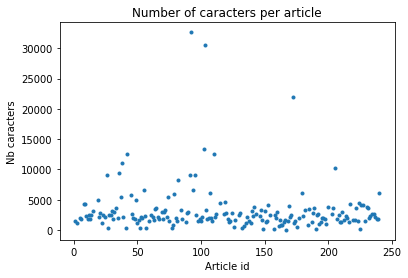

In [42]:
plt.plot(df_train['len_content'],'.')
plt.title('Number of caracters per article')
plt.xlabel('Article id')
plt.ylabel('Nb caracters')

Text(0, 0.5, 'Nb relevants words')

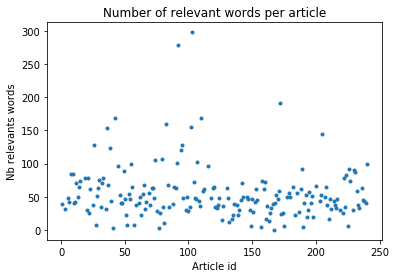

In [43]:
plt.plot(df_train['nb_relevant'],'.')
plt.title('Number of relevant words per article')
plt.xlabel('Article id')
plt.ylabel('Nb relevants words')

### It's prediction time !

In [44]:
X_train = df_train.sort_index()
Y_train = get_Y_train().sort_index()
X_test = df_test

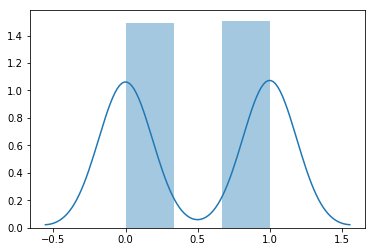

In [35]:
# real y-train distribution
sns.distplot(Y_train)

### Correlation

In [67]:
df = X_train
df['is_fake'] = Y_train
print(
    'Longeur_du_titre_',df.corr()['is_fake']['len_title'],
    '\nLongueur_du_contenu_',df.corr()['is_fake']['len_content'],
    '\nNombre_de_mots_importants_',df.corr()['is_fake']['nb_relevant'],
    '\nNombre_de_mots_',df.corr()['is_fake']['nb_words'],
    "\nNombre_d'entités_",df.corr()['is_fake']['nb_entity'],
    "\nNombre_de_mots_contenant majuscules_ou_en_majuscule_",df.corr()['is_fake']['nb_uppercase_words'])

Longeur_du_titre_ 0.1891528006269007 
Longueur_du_contenu_ -0.18831409746990668 
Nombre_de_mots_importants_ -0.24739609303303786 
Nombre_de_mots_ -0.17752786255857253 
Nombre_d'entités_ -0.14805385346131786 
Nombre_de_mots_contenant majuscules_ou_en_majuscule_ 0.07237534070039076


### Best parameters

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
bootstrap = [True,False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,Y_train)

rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.0s


KeyboardInterrupt: 

### Cross validation

In [37]:
#Based on a model and best parameters, get a cross val score
clf = RandomForestClassifier(n_estimators= 1400,min_samples_split= 2,min_samples_leaf=1,max_features='auto',max_depth=60,bootstrap=False)
np.mean(cross_val_score(clf,X_train,Y_train,cv=10))

0.8606140350877192

### With the help of the model we can predict

In [ ]:
clf = RandomForestClassifier(n_estimators= 1000,min_samples_split= 5,min_samples_leaf=2,max_features='sqrt',max_depth=100,bootstrap=False)
clf.fit(X_train,Y_train)
Y_test = clf.predict(X_test)

### Create a submission file

In [ ]:
now = str(datetime.datetime.now())[:19]
with open('../data/submissions/bogota_mates_submission_'+now+'.txt', 'w') as f:
    f.write('doc,class\n')
    for value,doc in zip(Y_test,X_test.index):
        f.write(str(doc)+ ',' + str(value)+"\n")

## NETWORK

In [ ]:
f = open('../data/newsUser.txt','r')
nb_news = pd.DataFrame([line.split() for line in f.readlines()],columns=['id_article','id_user','weight'])
f = open('../data/UserUser.txt','r')
follows = pd.DataFrame([line.split() for line in f.readlines()],columns=['follower','followed'])

In [ ]:
nb_news['id_article'][0]

In [ ]:
g = nx.Graph()
for i,val in enumerate(nb_news['id_article']):
    g.add_edges_from([(nb_news['id_article'][i],nb_news['id_user'][i])],weight=nb_news['weight'])

In [ ]:
degree = pd.Series([node[1] for node in g.degree])
sns.distplot(degree,kde=False,bins=20)
plt.show()

In [ ]:
# Degree
degree_centrality = nx.degree_centrality(g)

In [ ]:
degree_centrality